# XGBoost training
  
By Kelsey Yao  
  
Example: https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci/blob/main/ClimateBench_tutorials/xgboost_SHAP_example.ipynb

In [1]:
from utils import *
import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


xgboost version =  1.7.6


# Data Preprocessing
Split the data into training set and test set, and separate the inputs and the outputs

In [2]:
train_df, test_df = df_prep(file_dir)
train_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,58,3,11,0,58
1,19,0,19,0,8
2,38,1,38,0,35
3,59,1,18,0,59
4,46,1,24,3,46
...,...,...,...,...,...
18765,103,3,12,27,103
18766,38,1,19,0,38
18767,51,1,46,0,51
18768,172,6,19,22,172


In [3]:
test_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,235,3,158,1,235
1,123,1,35,0,123
2,39,1,39,1,38
3,37,2,15,0,37
4,39,1,39,1,18
...,...,...,...,...,...
4688,60,1,35,0,60
4689,40,1,29,3,40
4690,70,1,70,0,42
4691,52,2,13,0,52


In [4]:
# Separate the inputs and the outputs
X_train_df = train_df.iloc[:, 1:5]
print('<======================= X_train =======================>\n')
print(X_train_df)
y_train_df = train_df.iloc[:, :1]
print('<======================= y_train =======================>\n')
print(y_train_df)
X_test_df = test_df.iloc[:, 1:5]
print('<======================= X_test =======================>\n')
print(X_test_df)
y_test_df = test_df.iloc[:, :1]
print('<======================= y_test =======================>\n')
print(y_test_df)

<======================= X_train =======================>

       CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
0                 3               11              0               58
1                 0               19              0                8
2                 1               38              0               35
3                 1               18              0               59
4                 1               24              3               46
...             ...              ...            ...              ...
18765             3               12             27              103
18766             1               19              0               38
18767             1               46              0               51
18768             6               19             22              172
18769             1               66              0               90

[18770 rows x 4 columns]
<======================= y_train =======================>

       AQI Value
0          

# Data Normalization
We tried to use different data normalization strategies to address the skewness in the input distribution
The following four strategies are implemented:
1. Standardization as normal distribution: Find the mean and standard deviation of the input distribution and convert it to a standard normal distribution.
2. Normalization (min-max): Set the min and max values of the input distribution to 0 and 1, and normalize the distribution to values between 0 and 1 linearly.
3. Log transformation: Try to transform a skewed distribution to a normal distribution by taking the log of the input distribution.
4. Square root transformation: Try to transform a skewed distribution to a normal distribution by taking the square root of the input distribution.

In [5]:
# Select different normalization strategies, range is 1-4
method_selection = 4

if method_selection == 1:
    # Method 1. Standardization as normal distribution
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std
elif method_selection == 2:
    # Method 2. Normalization (min-max)
    max_val, min_val = X_train_df.max(), X_train_df.min()
    test_range = max_val - min_val
    X_train_df   = X_train_df/test_range
    X_test_df    = X_test_df/test_range
elif method_selection == 3:
    # Method 3. Log transformation
    # Avoid taking the log of 0s
    X_train_df   = pd.DataFrame(np.ma.log(X_train_df.values).filled(0), index=X_train_df.index, columns=X_train_df.columns)
    X_test_df    = pd.DataFrame(np.ma.log(X_test_df.values).filled(0), index=X_test_df.index, columns=X_test_df.columns)
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std
elif method_selection == 4:
    # Method 4. Square root transformation
    X_train_df   = np.sqrt(X_train_df)
    X_test_df    = np.sqrt(X_test_df)
    mean, std = X_train_df.mean(), X_train_df.std()
    X_train_df   = (X_train_df - mean)/std
    X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test_truth = y_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(18770, 4) (18770, 1)


# XGBoost construction
First by selecting hyperparameter settings randomly

In [6]:
# set up xgboost regressor
n_estimators  = 30     # specifies the number of decision trees to be boosted
learning_rate = 0.2    # learning_rate, range: [0,1]. THIS WAS NOT IN THE NORMAL RANDOM FOREST MODEL, AND IT IS IMPORTANT
gamma         = 3      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 10     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.8    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.8    # L2 regularization, range: [0,∞]
alpha         = 0.2    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'rmse' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

eval_set = [(X_train, y_train), (X_test, y_test_truth)]

xgb_regressor1 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              # eval_set = eval_set,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)


In [7]:
xgb_regressor1.fit(X_train, y_train,eval_set = eval_set,verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric='rmse',
             feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [8]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [9]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
# xgb_regressor1.save(os.path.join(model_path,'XGB_model.h5'))

Mean Absolute Error: 0.5199091086478064
Root Mean Squared Error: 3.2898039972252344


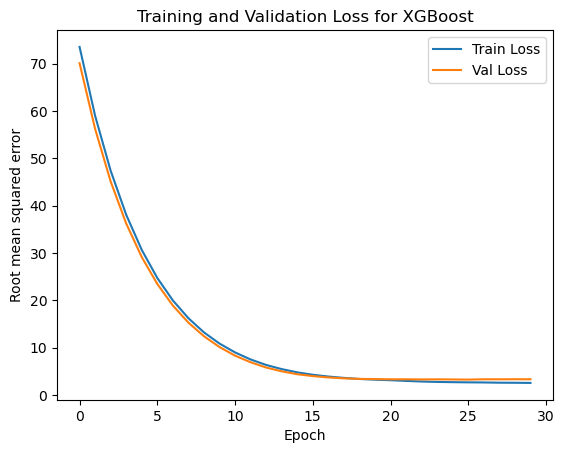

In [10]:
# generate predictions
y_test_pred1 = xgb_regressor1.predict(X_test)

# evaluate the predictions
mae1 = mean_absolute_error(y_test_truth, y_test_pred1)
print(f"Mean Absolute Error: {mae1}")

rmse1 = mean_squared_error(y_test_truth, y_test_pred1, squared=False)
print(f"Root Mean Squared Error: {rmse1}")

# plot training and val loss
results = xgb_regressor1.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Root mean squared error')
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
plt.plot(x_axis,results['validation_1']['rmse'], label='Val Loss')
plt.title('Training and Validation Loss for XGBoost')
plt.legend()
plt.show()

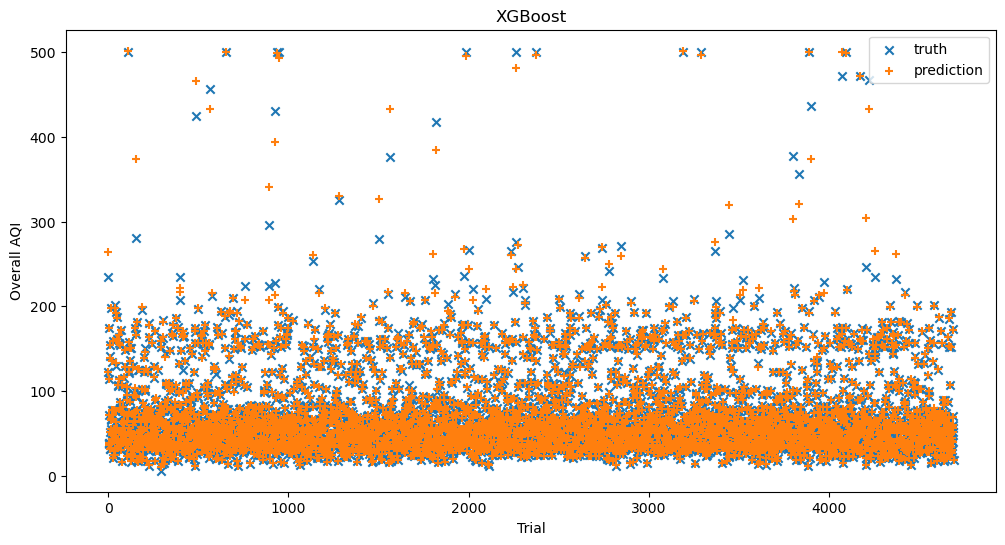

In [11]:
trial_test = 4693 # There are 4693 test datapoints
trial_array = np.arange(trial_test)
# y_test_truth = np.reshape(y_test_truth, -1)
# #print(y_test_truth)
# y_test_pre = np.reshape(y_test_pre, -1)
# #print(y_test_pre)

fig,ax = plt.subplots(figsize=(12,6))
plt.scatter(trial_array, np.reshape(y_test_truth, -1), marker='x', label='truth')
plt.scatter(trial_array, np.reshape(y_test_pred1, -1), marker='+', label='prediction')

ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Overall AQI')
plt.title('XGBoost')
plt.show()

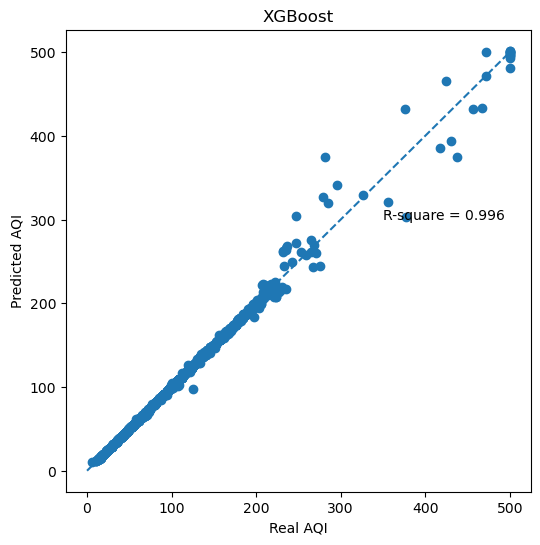

In [12]:
fig,ax = plt.subplots(figsize=(6,6))

from sklearn.metrics import r2_score

r2 = r2_score(np.reshape(y_test_truth, -1), np.reshape(y_test_pred1, -1))
plt.text(350, 300, f'R-square = {r2:.4}', fontsize=10)
plt.scatter(np.reshape(y_test_truth, -1), np.reshape(y_test_pred1, -1), marker='o')
line_array = np.arange(max((np.reshape(y_test_truth, -1))))
plt.plot(line_array, line_array, linestyle='dashed')
ax.set_xlabel('Real AQI')
ax.set_ylabel('Predicted AQI')
plt.title('XGBoost')

plt.show()

# Trying hyperparameter tuning
Using the hyperopt package

In [13]:
#import pip
#!pip install hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [14]:
# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15, 20]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8, 0.9]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]
eta_list = [0.05, 0.1, 0.15, 0.2]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 1, 9),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }


In [15]:
# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    xgb_regressor.fit(X_train, y_train,eval_set = eval_set,verbose=False)
    
    y_test_pred = xgb_regressor.predict(X_test)
    rmse = mean_squared_error(y_test_truth, y_test_pred, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

In [16]:
# find the best hyperparameters of 10 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)


loss (rmse): 3.376184126200273                        
n_estimators = 90; eta = 0.05; gamma = 4.918698041974586; max_depth = 15
subsample = 0.7; reg_lambda = 0.7; reg_alpha = 0.3; eval_metric = mape
----------------------------------------------------------------------------------------
loss (rmse): 3.570018821687765                                                 
n_estimators = 60; eta = 0.15; gamma = 3.7009990250704057; max_depth = 20      
subsample = 0.7; reg_lambda = 0.8; reg_alpha = 0.3; eval_metric = mape         
----------------------------------------------------------------------------------------
loss (rmse): 19.218697653050537                                                
n_estimators = 30; eta = 0.05; gamma = 4.94633497303756; max_depth = 15        
subsample = 1; reg_lambda = 0.8; reg_alpha = 0.1; eval_metric = logloss        
----------------------------------------------------------------------------------------
loss (rmse): 31.83505766238402                        

In [17]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


The best hyperparameters are :  

{'eta': 1, 'eval_metric': 1, 'gamma': 2.146711461432755, 'max_depth': 0, 'n_estimators': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0}
eta =  0.1


In [18]:
# build a regressor with the best hyperparameters
xgb_regressor2 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

xgb_regressor2.fit(X_train, y_train,eval_set = eval_set,verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='mae',
             feature_types=None, gamma=2.146711461432755, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [19]:
# generate predictions
y_test_pred2 = xgb_regressor2.predict(X_test)

# evaluate the predictions
mae2 = mean_absolute_error(y_test_truth, y_test_pred2)
print(f"Mean Absolute Error: {mae2}")

rmse2 = mean_squared_error(y_test_truth, y_test_pred2, squared=False)
print(f"Root Mean Squared Error: {rmse2}")



Mean Absolute Error: 0.7703872504275973
Root Mean Squared Error: 3.3228853382095256


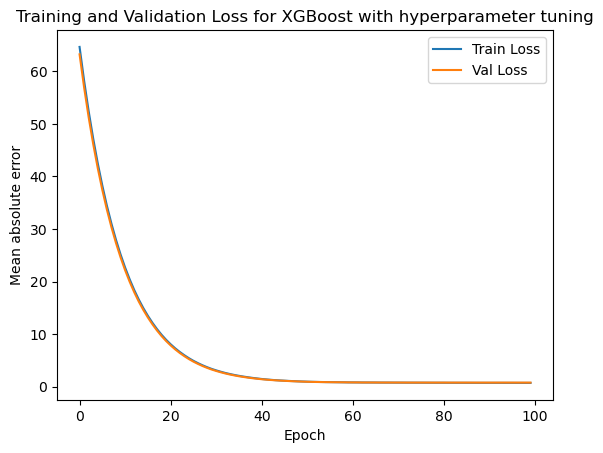

In [20]:
# plot training and val loss
results = xgb_regressor2.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.plot(x_axis, results['validation_0']['mae'], label='Train Loss')
plt.plot(x_axis,results['validation_1']['mae'], label='Val Loss')
plt.title('Training and Validation Loss for XGBoost with hyperparameter tuning')
plt.legend()
plt.show()

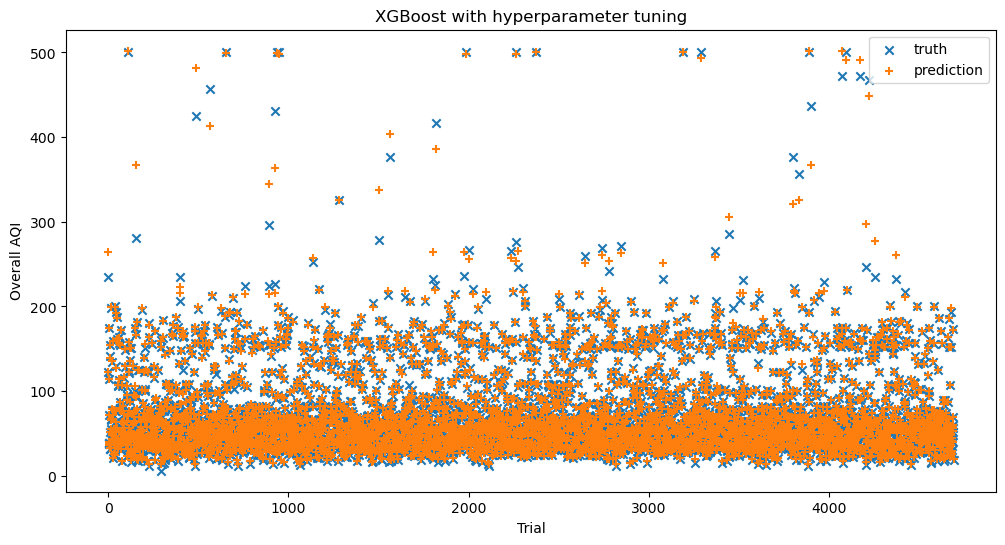

In [21]:
fig,ax = plt.subplots(figsize=(12,6))
plt.scatter(trial_array, np.reshape(y_test_truth, -1), marker='x', label='truth')
plt.scatter(trial_array, np.reshape(y_test_pred2, -1), marker='+', label='prediction')

ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Overall AQI')
plt.title('XGBoost with hyperparameter tuning')
plt.show()

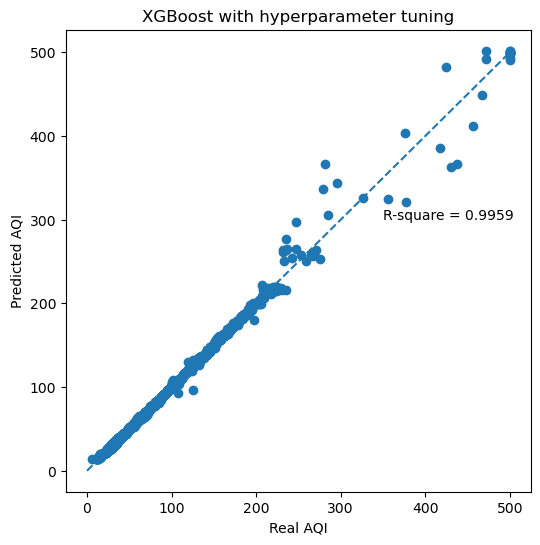

In [22]:
fig,ax = plt.subplots(figsize=(6,6))

# from sklearn.metrics import r2_score

r2 = r2_score(np.reshape(y_test_truth, -1), np.reshape(y_test_pred2, -1))
plt.text(350, 300, f'R-square = {r2:.4}', fontsize=10)
plt.scatter(np.reshape(y_test_truth, -1), np.reshape(y_test_pred2, -1), marker='o')
line_array = np.arange(max((np.reshape(y_test_truth, -1))))
plt.plot(line_array, line_array, linestyle='dashed')
ax.set_xlabel('Real AQI')
ax.set_ylabel('Predicted AQI')
plt.title('XGBoost with hyperparameter tuning')

plt.show()